## Setup

In [ ]:
# Transformers installation
!pip install transformers -q
!pip install datasets -q
!pip install torch -q

# automatic module update
%load_ext autoreload
%autoreload 2

# clonning all the modules
import os
if 'google.colab' in str(get_ipython()) and not os.getcwd().endswith('thesis_code'):
    !git clone https://github.com/iambackend/thesis_code    
    %cd thesis_code
else:
    if not os.getcwd().endswith('thesis_code'):
        %cd ..
! pwd

# reproducibility setup
import torch
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)
import random
random.seed(42)
import numpy as np
np.random.seed(42)

In [ ]:
# to update source codes if ran on colab
!git pull


## Regular train/val split

In [27]:
# import os
# import sys
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from data import get_compiled_dataset

train_dataset, test_dataset, encode_dict = get_compiled_dataset('data/PURE_and_others.csv')

In [23]:
from data import get_compiled_dataset
train_dataset, test_dataset, encode_dict = get_compiled_dataset('data/PURE_and_others.csv', 
                                                                allowed_labelers=['Aydar'],
#                                                                 allowed_labels=['Access control']
                                                               )
print(len(train_dataset))

554


In [3]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizerFast
from src.utils import compute_metrics

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# reset randomizers seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    evaluation_strategy='epoch',
    eval_steps=300,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encode_dict))

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,             # evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Runtime,Samples Per Second
1,1.762100,1.699020,0.257426,0.042904,0.166667,0.068241,12.018200,8.404000


/Users/Ouser/Documents/Thesis/thesis_code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=57, training_loss=1.8047848751670437, metrics={'train_runtime': 590.7808, 'train_samples_per_second': 0.096, 'total_flos': 55386657409824.0, 'epoch': 1.0})

## Results

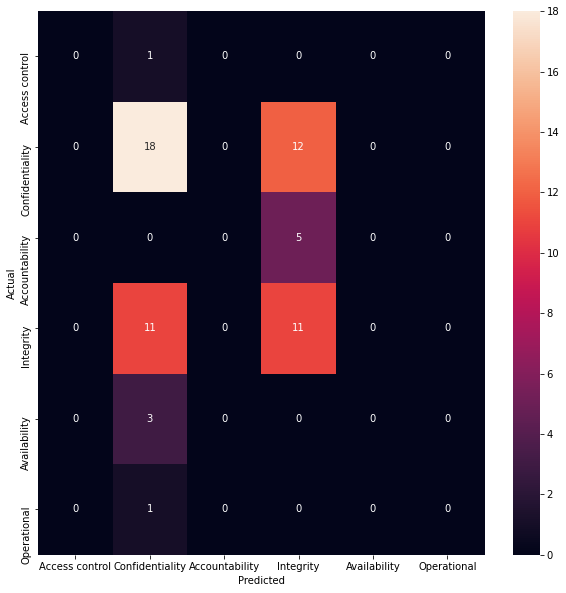

In [36]:
from src.utils import predict, show_confusion_matrix

y_true, y_pred = predict(model, test_dataset, encode_dict)
show_confusion_matrix(y_true, y_pred, encode_dict)

In [ ]:
y_true, y_pred = predict(model, train_dataset, encode_dict)
show_confusion_matrix(y_true, y_pred, encode_dict)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## 10-fold cross validation

In [38]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, DistilBertTokenizerFast

from src.utils import compute_metrics
from data import get_compiled_dataset, predict

# reset randomizers seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

train_datasets, test_datasets, encode_dict = get_compiled_dataset('data/PURE_and_others.csv',
                                                                type='10-fold',
#                                                                 allowed_labelers=['Aydar'],
#                                                                 allowed_labels=['Access control']
                                                               )


print(train_datasets)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=30,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    evaluation_strategy='epoch',
    eval_steps=300,
)

results = []
Y_true, Y_pred = [], []

for i, (train_dataset, test_dataset) in enumerate(zip(train_datasets, test_datasets)):
    
    print()
    print(f"FOLD NUMBER {i}")
    print()

    # reset randomizers seeds for reproducibility
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)
    
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(encode_dict))

    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=test_dataset,             # evaluation dataset
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()
    
    results.append(trainer.evaluate())
    y_true, y_pred = predict(model, test_dataset, encode_dict)
    Y_true.extend(y_true)
    Y_pred.extend(y_pred)
        

[<data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13c935f90>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13cd69dd0>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13b1a3990>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13b006f50>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13ccf2f90>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13ccf2d50>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13ccf20d0>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13ccf2050>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13cc01690>, <data.datasets.get_compiled_dataset.<locals>.OwnDataset object at 0x13ccf2fd0>]


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Runtime,Samples Per Second
1,1.704900,1.649975,0.467742,0.153711,0.183333,0.167083,8.217800,7.545000


/Users/Ouser/Documents/Thesis/thesis_code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/Ouser/Documents/Thesis/thesis_code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Results

In [42]:
accuracy, precision, recall, f1_score = 0, 0, 0, 0

for result in results:
    accuracy += result['eval_accuracy']
    precision += result['eval_precision']
    recall += result['eval_recall']
    f1_score += result['eval_f1']

accuracy /= 10
precision /= 10
recall /= 10
f1_score /= 10

print(f'accuracy: {accuracy}\nprecision: {precision}\nrecall: {recall}\nf1_score: {f1_score}')

accuracy: 0.04677419354838709
precision: 0.015371148459383754
recall: 0.018333333333333333
f1_score: 0.016708333333333332


In [ ]:
from src.utils import show_confusion_matrix

show_confusion_matrix(Y_true, Y_pred, encode_dict)

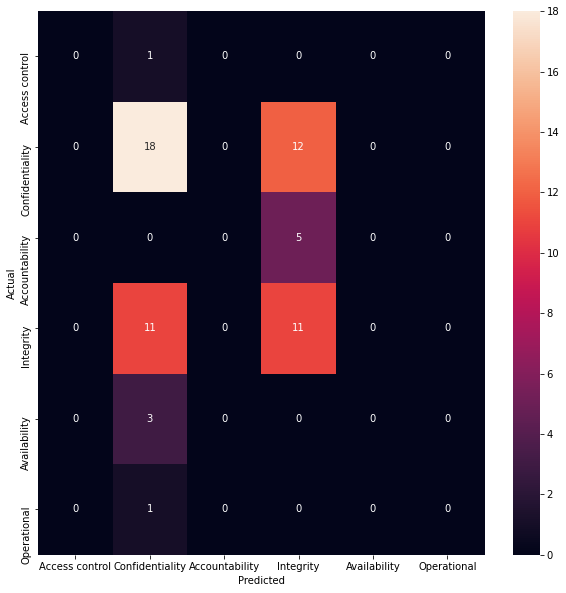

In [50]:
show_confusion_matrix(Y_true, Y_pred, encode_dict, normalized=True)